# Augmenting the dataset
Following the competition, Andras Zsom posted his method of tackling the challenge on his [blog](https://andraszsom.wordpress.com/), where he explained how he augmented the dataset with further data from Austin Animal Shelter. This contained information on the specifics of how, when and under what circumstances the animals *came into* the shelter, which naturally has a bearing on the outcome - and timing of this outcome - for each animal. Further, he took into account which animals were in the shelter at any given time. Andras' good spot of this data and his thought provoking method inspired me to emulate his approach in my own style.

First, load in the csv files provided on the [Austin Animal Shelter data portal](http://www.austintexas.gov/department/reports-1), merging them with the 'outcome' files provided in the competition:

In [1]:
import pandas as pd

## Import files and merge datasets
# Import supplementary intake files
files = ['./input/Austin_Animal_Center_FY14_Intakes.csv', './input/Austin_Animal_Center_FY15_Intakes.csv']
df_intake = pd.concat(pd.read_csv(f) for f in files)
df_intake.rename(columns={'Animal ID':'AnimalID'}, inplace=True)

# Import Kaggle-provided outcome files
df = pd.read_csv('./input/train.csv')
df['Regime'] = 'train'
df_test = pd.read_csv('./input/test.csv')
df_test['Regime'] = 'test'
df = df.append(df_test)

# Merge desired columns using left join on AnimalID
cols = ['AnimalID','Intake Date','Intake Time','Intake Type','Intake Condition', 'Age upon Intake']
df_combined = df.merge(df_intake[cols], on='AnimalID', how='left').drop_duplicates()
print(df_combined.apply(pd.Series.nunique))

# Change dates to datetime format
df_combined['Intake DateTime'] = df_combined['Intake Date'].map(str) + ' ' + df_combined['Intake Time']
df_combined.drop(['Intake Date','Intake Time'], axis=1, inplace=True)
print('Number of datetimes, pre-conversion (with errors): %d' % len(df_combined['Intake DateTime']))
print('Number of datetimes, pre-conversion (excl. errors): %d' % (len(df_combined['Intake DateTime'])-
                                                                  df_combined['Intake DateTime'].isnull().sum()))
df_combined['Intake DateTime'] = pd.to_datetime(df_combined['Intake DateTime'], infer_datetime_format=True, errors='raise')
print('Number of datetimes, post-conversion (excl. errors): %d' % (len(df_combined['Intake DateTime'])-
                                                                   df_combined['Intake DateTime'].isnull().sum()))
df_combined['DateTime'] = pd.to_datetime(df_combined['DateTime'])
df_combined.head()

AgeuponOutcome         45
AnimalID            26729
AnimalType              2
Breed                1678
Color                 411
DateTime            31413
ID                  11456
Name                 7968
OutcomeSubtype         16
OutcomeType             5
Regime                  2
SexuponOutcome          5
Intake Date           730
Intake Time          1101
Intake Type            24
Intake Condition       15
Age upon Intake        50
dtype: int64
Number of datetimes, pre-conversion (with errors): 39917
Number of datetimes, pre-conversion (excl. errors): 24504
Number of datetimes, post-conversion (excl. errors): 24504


,AgeuponOutcome,AnimalID,AnimalType,Breed,Color,DateTime,ID,Name,OutcomeSubtype,OutcomeType,Regime,SexuponOutcome,Intake Type,Intake Condition,Age upon Intake,Intake DateTime
0,1 year,A671945,Dog,Shetland Sheepdog Mix,Brown/White,2014-02-12 18:22:00,NaN,Hambone,NaN,Return_to_owner,train,Neutered Male,Stray,Normal,1 year,2014-02-02 09:31:00
1,1 year,A656520,Cat,Domestic Shorthair Mix,Cream Tabby,2013-10-13 12:44:00,NaN,Emily,Suffering,Euthanasia,train,Spayed Female,Owner Surrender,Normal,1 year,2013-10-13 11:49:00
2,2 years,A686464,Dog,Pit Bull Mix,Blue/White,2015-01-31 12:28:00,NaN,Pearce,Foster,Adoption,train,Neutered Male,Stray,Normal,2 years,2014-08-22 12:57:00
3,3 weeks,A683430,Cat,Domestic Shorthair Mix,Blue Cream,2014-07-11 19:09:00,NaN,NaN,Partner,Transfer,train,Intact Male,Stray,Sick,3 weeks,2014-07-10 12:05:00
4,2 years,A667013,Dog,Lhasa Apso/Miniature Poodle,Tan,2013-11-15 12:52:00,NaN,NaN,Partner,Transfer,train,Neutered Male,Stray,Normal,2 years,2013-11-11 11:38:00


Doing some tests, it appears some AnimalIDs appear more than once, suggesting some animals have returned to the shelter after a previously recorded outcome. Though the number of previous intakes is likely useful information, I'll be ignoring these for now because I'm short on time and will take only the most recent outcome.

In [2]:
print('Outcome dataframe: %d' % len(df))
print('Combined dataframe: %d' % len(df_combined))
print('Combined dataframe, AnimalID unique: %d' % df_combined['AnimalID'].nunique())
original_length = len(df_combined['AnimalID'])
print('Combined dataframe, AnimalID count: %d\n' % original_length)

# Record number of occurences of AnimalID
animalID_occurrences = df_combined['AnimalID'].value_counts().to_dict()

# Loop through occurrences, discarding anything other than the most recent
obsoletes = 0
for occurrence in animalID_occurrences:
    if animalID_occurrences[occurrence] > 1:
        # Get dates of each intake, find max
        df_intakes = df_combined[df_combined['AnimalID'] == occurrence]
        obsoletes += len(df_intakes) - 1
        latest_outcome = df_intakes['DateTime'].max()
        intake_list = df_intakes['Intake DateTime']
        latest_intake = intake_list[intake_list < latest_outcome].max()
        #print('Latest outcome / intake for %s: %s / %s' % (df_intakes['AnimalID'].iloc[0], latest_outcome, latest_intake))
        
        # Remove all rows except the latest
        df_combined.drop(df_combined[(df_combined['AnimalID'] == occurrence) & \
            (df_combined[df_combined['AnimalID'] == occurrence]['Intake DateTime'] != latest_intake)].index, inplace=True)

print('Combined dataframe, length with multiples removed: %d' % len(df_combined))
print('Obsoletes: %d' % obsoletes)
print('Removed: %d' % (original_length - len(df_combined)))

# Save to csv for later
#df_combined.to_csv('./output/train_merged.csv', index=False)

Outcome dataframe: 38185
Combined dataframe: 39917
Combined dataframe, AnimalID unique: 26729
Combined dataframe, AnimalID count: 39917

Combined dataframe, length with multiples removed: 38186
Obsoletes: 1732
Removed: 1731


*Note: 'Obsoletes' refers to records of the animal in the shelter before their most recent visit.* 

Out of interest, just check the typical duration an animal is in the shelter (i.e. the time from intake to outcome). 18 days appears to be reasonable but less than I expected.

In [3]:
# Get average time to resolution as a check 
df_temp = df_combined['DateTime'] - df_combined['Intake DateTime']
print df_temp.mean()

18 days 23:15:34.087735


### Perform pre-processing
I now start the pre-processing:
1. Separating the sex and neutered status of the animal.
2. Standardising ages by converting them to months.
3. Reducing the number of breeds by mapping them into breed 'groups' using Andras' data.
4. Removing the handling of names, only keeping whether the animal has a name.
5. Reducing the number of colours by taking only the first for multi-coloured animals.


In [4]:
## Perform preprocessing
import re
import numpy as np

def breed_to_breed_group(data_col):   
    """
    Function simplifies dog breeds into dog breed categories, yielding more
    examples per category. Accepts a dataframe column of dog breeds and returns
    a dataframe column of dog breeds mapped to categories. Function uses
    data and structure of Andy's Kaggle script, which can be found at: 
    kaggle.com/andraszsom/shelter-animal-outcomes/dog-breeds-dog-groups/comments
    """
    
    # Import Andy's breed groups as dictionary
    fname = './input/dog_breed_to_category.csv'
    breed_to_category_dict = pd.read_csv(fname, names=['Category'], index_col=0, header=None).to_dict()
    
    unknowns = []
    for idx, element in enumerate(data_col):
        # Simplify breed by removing unnecessary words
        element = element.replace(' Shorthair','')
        element = element.replace(' Medium Hair','')
        element = element.replace(' Longhair','')
        element = element.replace(' Wirehair','')
        element = element.replace(' Rough','')
        element = element.replace(' Smooth Coat','')
        element = element.replace(' Smooth','')
        element = element.replace(' Black/Tan','')
        element = element.replace('Black/Tan ','')
        element = element.replace(' Flat Coat','')
        element = element.replace('Flat Coat ','')
        element = element.replace(' Coat','')

        # If more than one breed, split using '/' separator
        if '/' in element:
            i = 0
            split_element = element.split('/')
            a = ''
            for j in split_element:
                if j[-3:] == 'Mix':
                    if not j[:-4] in breed_to_category_dict['Category'].keys():
                        a += 'Unknown Mix'
                        unknowns.append(j[:-4])
                    else:
                        a += breed_to_category_dict['Category'][j[:-4]]
                else:
                    if not j in breed_to_category_dict['Category'].keys():
                        a += 'Unknown'
                        unknowns.append(j)
                    else:
                        a += breed_to_category_dict['Category'][j]
                a += ' / '
            a = a[:-3]
            data_col.iloc[idx] = a
        else:
            if element[-3:] == 'Mix':
                data_col.iloc[idx] = element[:-4]
                if not element[:-4] in breed_to_category_dict['Category'].keys():
                    data_col.iloc[idx] = "Unknown Mix"
                    unknowns.append(element[:-4])
            else:
                data_col.iloc[idx] = element
                if not element in breed_to_category_dict['Category'].keys():
                    data_col.iloc[idx] = "Unknown"
                    unknowns.append(element)
                    
    print('Unknown dog breeds: %s\n' % sorted(list(set(unknowns))))
    
    breeds = set([val for val in breed_to_category_dict['Category'].keys()])
    # Map breed to category
    for breed in breeds:
        data_col.loc[data_col == breed] = breed_to_category_dict['Category'][breed]        
    return data_col

# ------------------------------------------------------------------
def find_number(string):
    number = re.match('^[0-9]+', string).group(0)
    return int(number)

# ------------------------------------------------------------------
def age_to_days(age):
    '''
    Takes list of strings with ages in the regex format ^[0-9]+\b\s+
    and returns a list of integers with the age in days. E.g. 
    '12 months' becomes '365'.
    '''
    if pd.isnull(age):
        return int(-1)
    
    if age[-3:] == 'day' or age[-4:] == 'days':
        age_number = find_number(age)
    elif age[-4:] == 'week' or age[-5:] == 'weeks':
        age_number = find_number(age) * 7
    elif age[-5:] == 'month' or age[-6:] == 'months':
        age_number = find_number(age) * 365/12
    elif age[-4:] == 'year' or age[-5:] == 'years':
        age_number = find_number(age) * 365
    else:
        age_number = -1
        print("Unknown age: %s" % age)

    return int(age_number)

# ------------------------------------------------------------------
# Separate sex and neutered status. The following functions were helpfully taken
# from Eugenia Uchaeva's 'Take a look at the data' script:
# https://www.kaggle.com/uchayder/shelter-animal-outcomes/take-a-look-at-the-data
def get_sex(element):
    """
    Takes string input, searches for sex within string, returns sex
    """
    element = str(element)
    if element.find('Male') >= 0: return 'male'
    if element.find('Female') >= 0: return 'female'
    return 'unknown'

def get_neutered(element):
    """
    Takes string input, searches for neutered status within string, returns 
    status
    """
    element = str(element)
    if element.find('Spayed') >= 0: return 'neutered'
    if element.find('Neutered') >= 0: return 'neutered'
    if element.find('Intact') >= 0: return 'intact'
    return 'unknown'
# ------------------------------------------------------------------

print(df_combined[df_combined['Regime'] == 'test'].shape)
print(df_test.shape)

# Split SexuopnOutcome into Sex and NeuteredStatus
df_combined['Sex'] = df_combined.SexuponOutcome.apply(get_sex)
df_combined['NeuteredStatus'] = df_combined.SexuponOutcome.apply(get_neutered)

# If AgeuponOutcome is missing, use 'Age upon Intake'; if both are NaN, remove the record. Convert ages to days.
df_combined.AgeuponOutcome = np.where(df_combined['AgeuponOutcome'] == np.nan, 
                                      df_combined['Age upon Intake'], df_combined['AgeuponOutcome'])
print("NaN values in AgeuponOutcome: %i" % df_combined['AgeuponOutcome'].isnull().sum())
print(len(df_combined[df_combined['Regime'] == 'test']))

df_combined_train = df_combined[df_combined['Regime'] == 'train']
len_auo1 = len(df_combined_train['AgeuponOutcome'])
df_combined_train.dropna(subset = ['AgeuponOutcome'], inplace = True)
len_auo2 = len(df_combined_train['AgeuponOutcome'])
df_combined_test = df_combined[df_combined['Regime'] == 'test']
df_combined = df_combined_train.append(df_combined_test)

print(len(df_combined[df_combined['Regime'] == 'test']))
print("NaN values removed from AgeuponOutcome: %i (column length: %i)" % (len_auo1 - len_auo2, len_auo2))
df_combined['AgeuponOutcome'] = df_combined['AgeuponOutcome'].apply(age_to_days)
print(len(df_combined[df_combined['Regime'] == 'test']))

# Categorise dog breeds into breed groups
df_combined.Breed[df_combined.AnimalType == 'Dog'] = breed_to_breed_group(df_combined.Breed[df_combined.AnimalType == 'Dog'])

# Encode whether animal has a name (note: loses info on whether name affects adoption for sake of simplicity!)
def has_name(name):
    if name != name or name == '': return 0
    else: return 1

df_combined.Name = df_combined['Name'].apply(has_name)
df_combined['Color_1'] = df_combined.Color.str.split('/| ').str.get(0)

drop_cols = ['SexuponOutcome', 'Color', 'Age upon Intake']
df_combined.drop(drop_cols, axis = 1, inplace = True)
new_length = df_combined.shape[0]
print('Preprocessing reduced the dataframe by %i rows.\n' % (original_length - new_length))
print(len(df_combined[df_combined['Regime'] == 'test']))

(11456, 16)
(11456, 9)
NaN values in AgeuponOutcome: 24
11456
11456
NaN values removed from AgeuponOutcome: 18 (column length: 26712)
11456
Unknown dog breeds: ['Alaskan Husky', 'American Eskimo', 'American Pit Bull Terrier', 'Anatol Shepherd', 'Bedlington Terr', 'Bichon Frise', 'Bluetick Hound', 'Boykin Span', 'Bruss Griffon', 'Bull Terrier Miniature', 'Carolina Dog', 'Cavalier Span', 'Chesa Bay Retr', 'Chinese Crested', 'Cirneco', 'Coton De Tulear', 'Dachshund Stan', 'Dandie Dinmont', 'Dogo Argentino', 'Dutch Shepherd', 'Eng Toy Spaniel', 'English Coonhound', 'English Pointer', 'English Shepherd', 'Entlebucher', 'Feist', 'German Pointer', 'Germaned Pointer', 'Glen Of Imaal', 'Hound', 'Hovawart', 'Jindo', 'Landseer', 'Lowchen', 'Mexican Hairless', 'Old English Bulldog', 'Patterdale Terr', 'Pbgv', 'Picardy Sheepdog', 'Plott Hound', 'Podengo Pequeno', 'Port Water Dog', 'Presa Canario', 'Redbone Hound', 'Schnauzer Giant', 'Sealyham Terr', 'Softed Wheaten Terrier', 'Spanish Mastiff', 'Swi

C:\Users\bw8\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\bw8\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Preprocessing reduced the dataframe by 1749 rows.

11456


### Understanding which animals are in the shelter at any particular time

In [5]:
## Understand which animals are in the shelter on each day
import time as time

day_count = (df_combined['DateTime'].max() - df_combined['DateTime'].min()).days
min_date = pd.to_datetime(df_combined['DateTime'].min().date()) + pd.Timedelta(hours=12)

for curr_date in (pd.to_datetime(min_date) + pd.Timedelta(days=1 * n) for n in range(day_count)): 
    # Collect the properties of the animals in the shelter at datetime
    df_register = df_combined.loc[(df_combined['Intake DateTime'] < curr_date) & \
                                 (df_combined['DateTime'] > curr_date)]
    # Save a csv file with the register
    df_register.to_csv('./input/animal_register_by_date/reg_' + str(curr_date.date()) + '.csv', index=False)

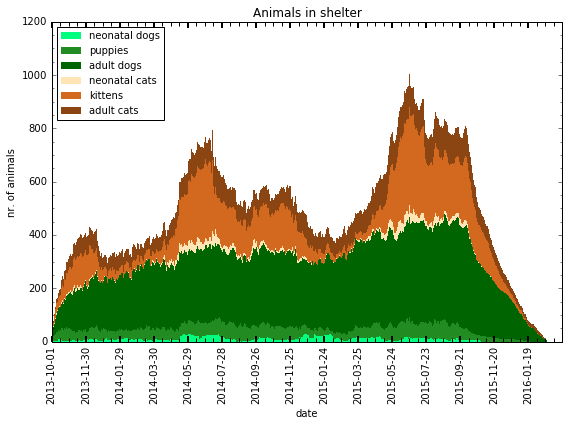

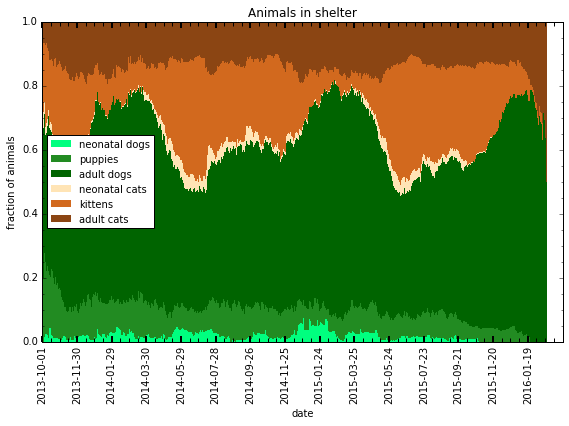

In [7]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Taken from Andras' notebook:
# Collect the files
files = []
dates = []
for file in os.listdir("./input/animal_register_by_date/"):
    if file.endswith(".csv"):
        files.append(file)
        dates.append(file[4:14])
        
nr_neonatal_dogs = np.zeros(len(dates))
nr_neonatal_cats = np.zeros(len(dates))
nr_puppies = np.zeros(len(dates))
nr_kitties = np.zeros(len(dates))
nr_dogs = np.zeros(len(dates))
nr_cats = np.zeros(len(dates))
nr_animals = np.zeros(len(dates))

for i in range(len(files)):
    df = pd.read_csv("./input/animal_register_by_date/" + files[i])
    age = df['AgeuponOutcome']
    nr_neonatal_dogs[i] = len(df[(df['AnimalType'] == 'Dog')&(age <= 42)])
    nr_neonatal_cats[i] = len(df[(df['AnimalType'] == 'Cat')&(age <= 42)])

    nr_puppies[i] = len(df[(df['AnimalType'] == 'Dog')&(age > 42)&(age < 365)])
    nr_kitties[i] = len(df[(df['AnimalType'] == 'Cat')&(age > 42)&(age < 365)])
    
    nr_dogs[i] = len(df[(df['AnimalType'] == 'Dog')&(age >= 365)])
    nr_cats[i] = len(df[(df['AnimalType'] == 'Cat')&(age >= 365)])
    
    nr_animals[i] = len(df)


plt.figure(figsize=(8,6))
width = 1e0
plt.title('Animals in shelter')
plt.xlabel('date')
plt.ylabel('nr. of animals')
plt1 = plt.bar(range(len(dates)), nr_neonatal_dogs, width,color='#00FF7F',edgecolor='none')
plt2 = plt.bar(range(len(dates)), nr_puppies, width,color='#228B22',
               bottom = nr_neonatal_dogs,edgecolor='none')
plt3 = plt.bar(range(len(dates)), nr_dogs, width,color='#006400',
               bottom = nr_neonatal_dogs+nr_puppies,edgecolor='none')
plt4 = plt.bar(range(len(dates)), nr_neonatal_cats, width,color='#FFE4B5',
               bottom = nr_neonatal_dogs+nr_puppies+nr_dogs,edgecolor='none')
plt5 = plt.bar(range(len(dates)), nr_kitties, width,color='#D2691E',
               bottom = nr_neonatal_dogs+nr_puppies+nr_dogs+nr_neonatal_cats,edgecolor='none')
plt6 = plt.bar(range(len(dates)), nr_cats, width,color='#8B4513',#
               bottom = nr_neonatal_dogs+nr_puppies+nr_dogs+nr_neonatal_cats+nr_kitties,edgecolor='none')
plt.legend([plt1,plt2,plt3,plt4,plt5,plt6],
           ['neonatal dogs','puppies','adult dogs','neonatal cats','kittens','adult cats'],loc=2,fontsize=10)
plt.xticks(range(len(dates))[::60], dates[::60], rotation=90)
plt.tight_layout(w_pad=0, h_pad=0)
plt.tick_params(axis='x', length=6, which='major',width=2)
plt.tick_params(axis='x', length=4, which='minor',width=1)
plt.minorticks_on()
plt.tight_layout(w_pad=0, h_pad=0)
#plt.savefig('figures/shelter_dist.pdf')
#plt.savefig('figures/shelter_dist.jpg',dpi=150)
plt.show()
plt.close()


plt.figure(figsize=(8,6))
width = 1e0
plt.title('Animals in shelter')
plt.xlabel('date')
plt.ylabel('fraction of animals')
plt1 = plt.bar(range(len(dates)), nr_neonatal_dogs/nr_animals, width,color='#00FF7F',edgecolor='none')
plt2 = plt.bar(range(len(dates)), nr_puppies/nr_animals, width,color='#228B22',
               bottom = (nr_neonatal_dogs)/nr_animals,edgecolor='none')
plt3 = plt.bar(range(len(dates)), nr_dogs/nr_animals, width,color='#006400',
               bottom = (nr_neonatal_dogs+nr_puppies)/nr_animals,edgecolor='none')
plt4 = plt.bar(range(len(dates)), nr_neonatal_cats/nr_animals, width,color='#FFE4B5',
               bottom = (nr_neonatal_dogs+nr_puppies+nr_dogs)/nr_animals,edgecolor='none')
plt5 = plt.bar(range(len(dates)), nr_kitties/nr_animals, width,color='#D2691E',
               bottom = (nr_neonatal_dogs+nr_puppies+nr_dogs+nr_neonatal_cats)/nr_animals,edgecolor='none')
plt6 = plt.bar(range(len(dates)), nr_cats/nr_animals, width,color='#8B4513',
               bottom = (nr_neonatal_dogs+nr_puppies+nr_dogs+nr_neonatal_cats+nr_kitties)/nr_animals,edgecolor='none')
plt.legend([plt1,plt2,plt3,plt4,plt5,plt6],
           ['neonatal dogs','puppies','adult dogs','neonatal cats','kittens','adult cats'],loc=6,fontsize=10)
plt.xticks(range(len(dates))[::60], dates[::60], rotation=90)
plt.tight_layout(w_pad=0, h_pad=0)
plt.tick_params(axis='x', length=6, which='major',width=2)
plt.tick_params(axis='x', length=4, which='minor',width=1)
plt.minorticks_on()
plt.tight_layout(w_pad=0, h_pad=0)
plt.show()
plt.close()

The cell below appends the dataframe with information about the number of animals of each type (whether a cat or dog, and one of three age descriptions) on the date at which the outcome occurred. 

I have used DateTime ('date of outcome') where Intake DateTime ('date of intake') is not available. This is a bit naughty as for the test animals it introduces a source of dataleak. I am going ahead with this, however, as I'm trying to write this from the perspective of a shelter owner who would use this script to predict the outcome of an animal entering the shelter *at the current time* and hence information about the current occupants would be available. As using the exact occupant numbers could lead the prediction algorithm to the date on which the animal outcomes occurred (and hence estimate the length of stay) I introduce gaussian noise on the shelter occupants when using DateTime to try to mitigate this.  

<font color = 'red'>WARNING: takes a while; about 10 minutes on Intel i5, 8GB RAM.</font> Could perhaps be optimised by doing groups of dates at once.

In [8]:
print(len(df_combined[df_combined['Regime'] == 'test']))

import itertools as itt
import datetime
def add_current_shelter_dist(row):
    """
    Takes the intake date and returns information of the animal shelter population on that day.
    Uses 'DateTime' where 'Intake DateTime' is not provided.
    """
    animal_type = ['Cat','Dog']
    age_ranges = [[0,42],[42,365],[365,3650],[3650,36500]]
    new_cols = list(itt.product(animal_type, age_ranges))
    
    # Open csv file relevant to date
    if os.path.isfile("./input/animal_register_by_date/reg_" + str(row['DateTime_temp'].date()) + '.csv'):
        df_shelter = pd.read_csv("./input/animal_register_by_date/reg_" + str(row['DateTime_temp'].date()) + '.csv')
    
        #print(df_shelter.head())
        #animal_ages = df_shelter['AgeuponOutcome']#.apply(lambda x: age_to_days(x))
        #print("CSV date: %s" % str(row['Intake DateTime'].date()))
        
        features = []
        val_total = len(df_shelter)
        val_dogs = len(df_shelter[df_shelter['AnimalType'] == 'Dog'])
        val_cats = len(df_shelter[df_shelter['AnimalType'] == 'Cat'])
        features.extend([val_total, val_dogs, val_cats])
        for col in new_cols:
            val = len(df_shelter[(df_shelter['AnimalType'] == col[0]) & 
                                 (df_shelter['AgeuponOutcome'] >= col[1][0]) & 
                                 (df_shelter['AgeuponOutcome'] < col[1][1])])
            features.append(val)
        return pd.Series(data=features)
    else:
        return pd.Series(data = np.zeros(len(cols) + 3) - 1)

# If 'Intake DateTime' is not available, use 'DateTime' but add Gaussian noise.
df_combined['DateTime_temp'] = df_combined['Intake DateTime'].fillna(df_combined['DateTime'] - 
                                                            datetime.timedelta(days=int(np.random.normal(0,1,1) * 60e0)))
print(str(datetime.datetime.now()))

df_shelter_cols = df_combined.apply(lambda row: add_current_shelter_dist(row), axis=1)
col_names = list(df_shelter_cols.columns.values)
df_shelter_cols.rename(columns=dict(zip(col_names, ['shelter_dist_' + str(x) for x in col_names])), inplace=True)
df_combined = df_combined.join(df_shelter_cols)

# Set NaN values in shelter_dist_9 and _10 to zero
df_combined['shelter_dist_9'].fillna(0, inplace=True)
df_combined['shelter_dist_10'].fillna(0, inplace=True)
df_combined.drop('DateTime_temp', axis=1, inplace=True)

print(str(datetime.datetime.now()))
print(len(df_combined[df_combined['Regime'] == 'test']))

11456
2016-10-25 00:00:01.243000
2016-10-25 00:09:54.971000
11456


In [9]:
df_combined['year'] = df_combined['DateTime'].dt.year
df_combined['month'] = df_combined['DateTime'].dt.month
df_combined['hour'] = df_combined['DateTime'].dt.hour + df_combined['DateTime'].dt.minute / 60e0
df_combined['wday'] = df_combined['DateTime'].dt.dayofweek
df_combined['qtr'] = df_combined['DateTime'].dt.quarter
df_combined['day'] = df_combined['DateTime'].dt.day

df_combined['year_intake'] = df_combined['Intake DateTime'].dt.year
df_combined['month_intake'] = df_combined['Intake DateTime'].dt.month
df_combined['hour_intake'] = df_combined['Intake DateTime'].dt.hour + df_combined['DateTime'].dt.minute / 60e0
df_combined['wday_intake'] = df_combined['Intake DateTime'].dt.dayofweek
df_combined['qtr_intake'] = df_combined['Intake DateTime'].dt.quarter
df_combined['day_intake'] = df_combined['Intake DateTime'].dt.day

df_combined.drop(['DateTime','Intake DateTime'], axis=1, inplace=True)
df_combined['year_intake'].fillna(df_combined['year'], inplace=True)
df_combined['month_intake'].fillna('-1', inplace=True)
df_combined['hour_intake'].fillna('-1', inplace=True)
df_combined['wday_intake'].fillna('-1', inplace=True)
df_combined['qtr_intake'].fillna('-1', inplace=True)
df_combined['day_intake'].fillna('-1', inplace=True)

C:\Users\bw8\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\internals.py:4417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  comp = (nn == nn_at)


Remove obvious errors in the intake columns:

In [10]:
print(len(df_combined[df_combined['Regime'] == 'test']))

vc_intake = [('Intake Type', df_combined['Intake Type'].value_counts(), 122, ''), 
             ('Intake Condition', df_combined['Intake Condition'].value_counts(), 10, 'Public Assist')]

for col_name, col, vc_max, exception in vc_intake:
    repl_list = col[col < vc_max].index
    repl_list = repl_list[repl_list != exception]
    df_combined[col_name][df_combined[col_name].isin(repl_list)] = None
    print(df_combined[col_name].value_counts())

print(len(df_combined[df_combined['Regime'] == 'test']))

11456
Stray                 17053
Owner Surrender        4199
Public Assist          1367
Euthanasia Request      122
Name: Intake Type, dtype: int64
Normal           19943
Injured           1070
Sick               804
Nursing            729
Aged                98
Other               54
Feral               33
Stray               17
Pregnant            10
Public Assist        2
Name: Intake Condition, dtype: int64
11456


C:\Users\bw8\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
def one_hot_encode(df_train, df_test, cols):
    """ Encodes variables. Modified from Andras' work."""
    for col in cols:
        train = df_train[col]
        test = df_test[col]

        encoded = pd.get_dummies(pd.concat([train,test], axis=0))
        train_rows = train.shape[0]

        train_encoded = encoded.iloc[:train_rows, :]
        test_encoded = encoded.iloc[train_rows:, :] 

        df_train = df_train.join(train_encoded, lsuffix='_left', rsuffix='_right')
        df_test = df_test.join(test_encoded, lsuffix='_left', rsuffix='_right')

        df_train.drop(col, axis=1, inplace=True)
        df_test.drop(col, axis=1, inplace=True)

    return df_train, df_test

#print list(df_combined.columns.values)
#['AgeuponOutcome', 'AnimalID', 'AnimalType', 'Breed', 'DateTime', 'ID', 'Name', 'OutcomeSubtype',
# 'OutcomeType', 'Regime', 'Intake Type', 'Intake Condition', 'Intake DateTime', 'Sex', 
# 'NeuteredStatus', 'Color_1', 'shelter_dist_0', 'shelter_dist_1', 'shelter_dist_2','shelter_dist_3', 
# 'shelter_dist_4', 'shelter_dist_5', 'shelter_dist_6', 'shelter_dist_7', 'shelter_dist_8']

print(len(df_combined[df_combined['Regime'] == 'test']))

df_combined.drop('ID', axis=1, inplace=True)
cols = ['AnimalType','Breed','Intake Type','Intake Condition','Sex','NeuteredStatus','Color_1']
df_train, df_test = one_hot_encode(df_combined[df_combined['Regime'] == 'train'],
                                   df_combined[df_combined['Regime'] == 'test'],
                                   cols)
df_train.drop('Regime', axis=1, inplace=True)
df_test.drop('Regime', axis=1, inplace=True)
print(len(df_test))
# Save a csv file with the dataframes
df_train.to_csv('./input/df_train.csv', index=False)
df_test.to_csv('./input/df_test.csv', index=False)

11456
11456


In [1]:
## Re-import incase I'm running the workbook from here,
## where df_train and df_test have already been created.
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import cross_validation

IMPORT_FROM_CSV = 1
if IMPORT_FROM_CSV == 1:
    df_train = pd.read_csv('./input/df_train.csv')
    df_test = pd.read_csv('./input/df_test.csv')
    print('Shape of df_train: %s' % (df_train.shape,))
    print('Shape of df_test: %s' % (df_test.shape,))
    
df_data_labels_train = df_train['OutcomeType']
df_data_labels_test = df_test['OutcomeType']
lab_enc = preprocessing.LabelEncoder()
df_data_labels_train = lab_enc.fit(df_data_labels_train).transform(df_data_labels_train)

cols = ['AnimalID','OutcomeType','OutcomeSubtype']
df_train.drop(cols, axis=1, inplace=True)
df_test.drop(cols, axis=1, inplace=True)

X_train = df_train
y_train = df_data_labels_train
X_test = df_test
y_test = df_data_labels_test

Shape of df_train: (26712, 240)
Shape of df_test: (11456, 240)


## Identify suitable algorithms by scoring on training data

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

### Train a classifier
##X_train, X_test, y_train, y_test = cross_validation.train_test_split(
##    df_train, df_data_labels, test_size = 0.33, random_state = 0)

# Fit scaler on x_train (for training score estimation)
xy_scaler = preprocessing.StandardScaler()
xy_scaler.fit(X_train)
X_train = xy_scaler.transform(X_train)
##X_test = xy_scaler.transform(X_test)

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis", "AdaBoosted decision trees"]

knn = KNeighborsClassifier(5)
linear_svm = svm.SVC(kernel="linear", C=0.025)
rbf_svm = svm.SVC(gamma=2, C=1)
d_tree = DecisionTreeClassifier(max_depth=5)
rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
adaboost = AdaBoostClassifier()
naive_bayes = GaussianNB()
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
adaboost_rf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                         algorithm="SAMME",
                         n_estimators=200)

classifiers = [
    knn,
    linear_svm,
    rbf_svm,
    d_tree,
    rf,
    adaboost,
    naive_bayes,
    lda,
    qda,
    adaboost_rf
]

def est_score(X, y):

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        clf.fit(X, y)
        score = clf.score(X, y)
        print(name, score)
        
est_score(X_train, y_train)

('Nearest Neighbors', 0.71466007786762509)
('Linear SVM', 0.67542677448337829)
('RBF SVM', 0.99876460017969448)
('Decision Tree', 0.65820604971548369)
('Random Forest', 0.58670260557053011)
('AdaBoost', 0.66520664869721469)
('Naive Bayes', 0.03380503144654088)

C:\Users\bw8\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\bw8\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")



('Linear Discriminant Analysis', 0.6753893381251872)
('Quadratic Discriminant Analysis', 0.038222521713087751)
('AdaBoosted decision trees', 0.70301737047020063)


C:\Users\bw8\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## Use promising algorithm to generate cross-validated results on training set

In [2]:
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.multiclass import OneVsRestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, log_loss

## Train a classifier
X_train_cv, X_test_cv, y_train_cv, y_test_cv = cross_validation.train_test_split(
    df_train, df_data_labels_train, test_size = 0.3, random_state = 0)

# Fit scaler on df_train (for test set evaluation)
xy_scaler = preprocessing.StandardScaler()
xy_scaler.fit(X_train_cv)
X_train_cv = xy_scaler.transform(X_train_cv)
X_test_cv = xy_scaler.transform(X_test_cv)

# Install PCA or FA to reduce dimensions (currently set to use PCA)
n_features = X_train_cv.shape[1]
n_components = np.arange(0, n_features, 1) #options

def compute_scores(X):
    # Fit the models
    pca = PCA()
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_validation.cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_validation.cross_val_score(fa, X)))
    
    return pca_scores, fa_scores

#for x in [(X_train)]:
#    pca_scores, fa_scores = compute_scores(x)
#    n_components_pca = n_components[np.argmax(pca_scores)]
#    n_components_fa = n_components[np.argmax(fa_scores)]
#
#    #pca = PCA(n_components='mle')
#    #pca.fit(x)
#    #n_components_pca_mle = pca.n_components_
#
#    print("best n_components by PCA CV = %d" % n_components_pca)
#    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
#    #print("best n_components by PCA MLE = %d" % n_components_pca_mle)
#
#
#pca = PCA(n_components= n_components_pca)
#X_train = pca.fit(X_train).transform(X_train)
#
##pca = PCA(n_components= n_components_pca_mle)
##X_train = pca.fit(X_train).transform(X_train)
#
##fa = FactorAnalysis(n_components= n_components_fa)
##X_train = fa.fit(X_train).transform(X_train)

## SVM
# Define SVM - basic, not optimised. Use cross validation / grid search 
# to find optimal hyperparameters
cv = cross_validation.ShuffleSplit(X_train.shape[1], n_iter=50,
                                   test_size=0.1, random_state=0) 
clf_svm = OneVsRestClassifier(svm.SVC(kernel='rbf', decision_function_shape='ovr', probability=True))
params = {
    'estimator__C': [0.001, 0.1, 1, 100],
    'estimator__gamma': [0.0001, 0.01, 1, 100]
}
clf_svm = GridSearchCV(clf_svm, cv=cv, param_grid=params)
clf_svm.fit(X_train_cv, y_train_cv)
y_pred_test = clf_svm.predict(X_test_cv)
y_pred_test_prob = clf_svm.predict_proba(X_test_cv)
print('Best parameters: %s' % clf_svm.best_params_)
print('Best score: %s' % clf_svm.best_score_)
print("Accuracy:",accuracy_score(y_test_cv, y_pred_test))
print("log_loss:", log_loss(y_test_cv, y_pred_test_prob))

## Logistic regression - use cross val!!!
clf_lr = LogisticRegression()
clf_lr.fit(X_train_cv, y_train_cv)
y_pred_test = clf_lr.predict(X_test_cv)
y_pred_test_prob = clf_lr.predict_proba(X_test_cv)
print(classification_report(y_test_cv, y_pred_test))
print("Accuracy:",accuracy_score(y_test_cv, y_pred_test))
print("log_loss:", log_loss(y_test_cv, y_pred_test_prob))



Best parameters: {'estimator__C': 100, 'estimator__gamma': 0.0001}
Best score: 0.6575
('Accuracy:', 0.65685051160469177)
('log_loss:', 0.93487807648451782)
             precision    recall  f1-score   support

          0       0.66      0.87      0.75      3217
          1       0.00      0.00      0.00        68
          2       0.66      0.27      0.38       507
          3       0.59      0.45      0.51      1398
          4       0.74      0.66      0.70      2824

avg / total       0.67      0.68      0.66      8014

('Accuracy:', 0.67656600948340406)
('log_loss:', 0.84940307182547703)


C:\Users\bw8\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [3]:
from sklearn import tree
clf_dt = tree.DecisionTreeClassifier()
clf_dt = clf_dt.fit(X_train_cv, y_train_cv)
y_pred_test = clf_dt.predict(X_test_cv)
y_pred_test_prob = clf_dt.predict_proba(X_test_cv)
print(classification_report(y_test_cv, y_pred_test))
print("Accuracy:",accuracy_score(y_test_cv, y_pred_test))
print("log_loss:", log_loss(y_test_cv, y_pred_test_prob))

             precision    recall  f1-score   support

          0       0.72      0.71      0.71      3217
          1       0.25      0.21      0.23        68
          2       0.47      0.41      0.44       507
          3       0.49      0.52      0.50      1398
          4       0.69      0.70      0.70      2824

avg / total       0.65      0.65      0.65      8014

('Accuracy:', 0.64911405041177939)
('log_loss:', 12.119171352943459)


In [4]:
from sklearn.ensemble import VotingClassifier
clf_ens = VotingClassifier(estimators=[('svc', clf_svm), ('lr', clf_lr), ('dt', clf_dt)], voting='soft', weights=[1,1,1])
clf_ens.fit(X_train_cv, y_train_cv)
y_pred_test = clf_ens.predict(X_test_cv)
y_pred_test_prob = clf_ens.predict_proba(X_test_cv)

print(classification_report(y_test_cv, y_pred_test))
print("Accuracy:",accuracy_score(y_test_cv, y_pred_test))
print("log_loss:", log_loss(y_test_cv, y_pred_test_prob))

             precision    recall  f1-score   support

          0       0.72      0.76      0.74      3217
          1       0.00      0.00      0.00        68
          2       0.65      0.36      0.46       507
          3       0.54      0.52      0.53      1398
          4       0.70      0.74      0.72      2824

avg / total       0.67      0.68      0.67      8014

('Accuracy:', 0.67793860743698531)
('log_loss:', 0.81712078055464166)


## Use promising algorithm on whole training set to generate results for test set

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import learning_curve, validation_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve. Taken from:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html.
    Currently fails.
    """
    print train_sizes
    print type(train_sizes)
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
                estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# ------------------------------------------------------------------
def plot_validation_curve(estimator, X, y, param_range=np.logspace(-9, 3, 9), cv=None):

    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name="estimator__gamma", param_range=param_range,
        cv=cv, scoring="accuracy", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with SVM")
    plt.xlabel("$\gamma$")
    plt.ylabel("Score")
    #plt.ylim(0.0, 1.1)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    return plt

## Plot learning curve for best params
#title = 'Learning curve (SVM)'
#plot_learning_curve(clf_ens, title, X_train_cv, y_train_cv, ylim=(0.6, 1.05), cv=cv)
#plt.show()

## Plot validation curve
plot_validation_curve(clf_ens, X_train_cv, y_train_cv, cv=cv)
plt.show()

ImportError: cannot import name validation_curve

In [6]:


##X_test = fa.transform(X_test)
clf.fit(X_train, y_train)
predicted = clf.predict_proba(X_test)

##y = np.bincount(predicted)
##ii = np.nonzero(y)[0]
##zip(ii,y[ii])
print(predicted[0:20])

[[  1.83069053e-02   1.53439717e-02   2.28205966e-02   2.64686850e-01
    6.78841676e-01]
 [  7.79159552e-01   1.17163491e-03   8.65370616e-03   1.44733246e-01
    6.62818605e-02]
 [  5.33821328e-01   9.14746547e-03   1.41819002e-02   8.67468257e-02
    3.56102480e-01]
 [  1.89957870e-01   4.71135255e-03   3.91330237e-02   2.74569643e-01
    4.91628111e-01]
 [  5.38864418e-01   1.24829798e-03   8.96941368e-03   3.64339003e-01
    8.65788674e-02]
 [  3.77206624e-01   4.24676259e-03   2.06386004e-02   3.26187862e-01
    2.71720152e-01]
 [  6.98246503e-02   8.37797006e-03   2.50919685e-01   3.56770993e-01
    3.14106702e-01]
 [  5.64890564e-01   8.51989833e-03   1.08734211e-02   2.19502421e-02
    3.93765874e-01]
 [  7.48154778e-01   1.52954966e-03   7.74490061e-03   1.80651892e-01
    6.19188792e-02]
 [  4.87073739e-01   1.22548258e-03   3.87723350e-02   3.68552976e-01
    1.04375467e-01]
 [  5.96709530e-01   1.55339774e-03   9.77631916e-03   2.61853679e-01
    1.30107075e-01]
 [  5.5716

In [8]:
def export_to_csv(pred):
    """
    Add headers and export the predictions to csv.
    """
    
    f = open('./Output/shelter_animal_outcomes_results_v3.0.csv','w')
    result_str = 'ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer\n'
    total = 1
    for i in range(len(pred)):
        for j in range(len(pred[i])):
            result_str += str(pred[i][j].astype(float)) + ','
        result_str += '\n'
        total += 1
    f.write(result_str)
    print('Wrote %i records to csv file.' % total)
    return

#print('Shape of X_test: %s' % (X_test.shape,))
#X_test = fa.transform(X_test)
#print('Shape of X_test: %s' % (X_test.shape,))
#predicted = clf_tuned.predict(X_test)
#print('Shape of predicted: %s' % (predicted.shape,))

#df_test = df_test.set_index('ID', drop = True)
#print('Preparing to scale the following dataframe:\n')
#print(df_test.head())

##predicted = pd.get_dummies(predicted)

X_test_ID = range(1, len(X_test)+1)
predicted_with_ID = np.append(pd.DataFrame(X_test_ID), predicted, 1)
export_to_csv(predicted_with_ID)

print('Complete!')

Wrote 11457 records to csv file.
Complete!
